## Reading the libraries, data and trained models

In [2]:
# Libraries

import pandas as pd
import numpy as np

import joblib

import dalex as dx

/home/karolina/XAI-project/.venv/lib/python3.12/site-packages/dalex/_global_checks.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/karolina/XAI-project/.venv/lib/python3.12/site-packages/dalex/_explainer/helper.py:16: SyntaxWarning: invalid escape sequence '\.'
  model_package = re.search("(?<=<class ').*?(?=\.)", str(type(model)))[0]


In [3]:
# Data

X_test = pd.read_csv("../data/X_test_data.csv")
X_train = pd.read_csv("../data/X_train_data.csv")
y_test = pd.read_csv("../data/y_test_data.csv")
y_train = pd.read_csv("../data/y_train_data.csv")

print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape :", X_test.shape, y_test.shape)

Train set shape: (6154, 27) (6154, 1)
Test set shape : (2638, 27) (2638, 1)


In [4]:
X_test

,age_of_series,r_rated,no_of_seasons,sentiment,multiple_platforms,netflix,hulu,prime_video,true_crime,world_war,...,genre_crime,genre_drama,genre_anime,genre_comedy,genre_documentary,genre_reality,genre_fiction,genre_actionadventure,genre_homegarden,genre_standuptalk
0,45,0,40,0.6344,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,1,2,-0.1531,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,6,1,4,-0.7512,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
3,5,0,1,-0.9403,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,8,0,5,-0.8451,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633,10,0,7,-0.3088,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2634,4,0,1,-0.5267,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2635,10,0,4,0.8779,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2636,13,0,1,0.8360,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [6]:
# Models

model_files = {
    'RF all vars': '../models/shows_rf_all_vars.joblib',
    'RF selected vars': '../models/shows_rf_limited_vars.joblib',
    'XGB all vars': '../models/shows_xgb_all_vars.joblib',
    'XGB selected vars': '../models/shows_xgb_limited_vars.joblib'
}

models = {name: joblib.load(path) for name, path in model_files.items()}

In [7]:
X_test_transformed_all_xgb = pd.DataFrame(
        models['XGB all vars'].named_steps['preprocess'].transform(X_test),
        columns=models['XGB all vars'].named_steps['preprocess'].get_feature_names_out()
    )

X_test_transformed_limited_xgb = pd.DataFrame(
        models['XGB selected vars'].named_steps['preprocess'].transform(X_test),
        columns=models['XGB selected vars'].named_steps['preprocess'].get_feature_names_out()
    )

X_test_transformed_all_rf = pd.DataFrame(
        models['RF all vars'].named_steps['preprocess'].transform(X_test),
        columns=models['RF all vars'].named_steps['preprocess'].get_feature_names_out()
    )

X_test_transformed_limited_rf = pd.DataFrame(
        models['RF selected vars'].named_steps['preprocess'].transform(X_test),
        columns=models['RF selected vars'].named_steps['preprocess'].get_feature_names_out()
    )

## Residual analysis

In [8]:
# Creating the explainers

# Set an empty dictionary
dalex_explainers = {}

for name, model in models.items():
    
    X_test_transformed = pd.DataFrame(
        model.named_steps['preprocess'].fit_transform(X_test),
        columns=model.named_steps['preprocess'].get_feature_names_out()
    )

    # Explainer on original scale (1-10)
    dalex_explainers[name] = dx.Explainer(
        model.named_steps['model'],
        X_test_transformed,
        y=y_test,
        label=name,
        predict_function=lambda m, x: m.predict(x).flatten()
    )


Preparation of a new explainer is initiated

  -> data              : 2638 rows 27 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 2638 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : RF all vars
  -> predict function  : <function <lambda> at 0x7f9fe3e1a980> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.


/home/karolina/XAI-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


  -> predicted values  : min = 4.58, mean = 6.93, max = 8.37
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)


/home/karolina/XAI-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


  -> residuals         : min = -5.95, mean = 0.0167, max = 3.2
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 2638 rows 20 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 2638 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : RF selected vars
  -> predict function  : <function <lambda> at 0x7f9fcb68a160> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.


/home/karolina/XAI-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


  -> predicted values  : min = 4.92, mean = 6.93, max = 8.32
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)


/home/karolina/XAI-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


  -> residuals         : min = -5.94, mean = 0.0157, max = 2.93
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 2638 rows 27 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 2638 values
  -> model_class       : xgboost.sklearn.XGBRegressor (default)
  -> label             : XGB all vars
  -> predict function  : <function <lambda> at 0x7f9fe407c5e0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 4.4, mean = 6.93, max = 8.59
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -5.88, mean = 0.0141, max = 3.14
  -> model_info        : package xgboost

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 2

In [9]:
# Compare the performance of all models

pd.concat((dalex_explainers['XGB all vars'].model_performance().result, dalex_explainers['XGB selected vars'].model_performance().result, dalex_explainers['RF all vars'].model_performance().result, dalex_explainers['RF selected vars'].model_performance().result))

,mse,rmse,r2,mae,mad
XGB all vars,1.143736,1.069456,0.175867,0.793841,0.618788
XGB selected vars,1.146663,1.070823,0.173759,0.794820,0.628344
RF all vars,1.145634,1.070343,0.174500,0.798330,0.624668
RF selected vars,1.145494,1.070278,0.174600,0.798003,0.632907


The errors and the R2 are not the best but the data is quite complex - we are having quite scarce information and we are trying to get some insight from it. The performance is better in XGB models.

In [ ]:
# Residual plot
dalex_explainers['XGB all vars'].model_diagnostics().plot(dalex_explainers['XGB selected vars'].model_diagnostics())


We see some problems - a slight trend sloping downwards and quite high variability of the residuals. That shows that the model's predictive accuracy is not that good.

## Permutation importance

In [ ]:
for name, explainer in dalex_explainers.items():
    print(f"{name}")
    explainer.model_parts().plot(title=f"Permutation Importance – {name}")

XGB all vars


XGB selected vars


Permutation importance helps us identify which variables are most influential in the model. By shuffling a given variable and observing the drop in model performance, we can determine how much the model depends on that variable. In our case, the variables that have the greatest impact appear to be whether the series is a documentary, reality show, or drama, as well as the number of seasons.

In [11]:
# Compute permutation-based variable importance
vi = dalex_explainers['XGB all vars'].model_parts()

# Sort by importance (drop in performance when permuted)
top_features = vi.result.sort_values(by="dropout_loss", ascending=False)

# Display top 10 features
top_features[["variable", "dropout_loss"]].head(20)

,variable,dropout_loss
28,_baseline_,1.298578
27,all_vars__genre_documentary,1.142917
26,all_vars__genre_reality,1.129090
25,all_vars__genre_drama,1.123802
24,all_vars__no_of_seasons,1.110404
23,all_vars__age_of_series,1.107119
22,all_vars__sentiment,1.102063
21,all_vars__genre_anime,1.097087
20,all_vars__r_rated,1.095847
19,all_vars__netflix,1.091236


In [12]:
top_features = top_features[~top_features['variable'].isin(['_baseline_', '_full_model_'])][:12]['variable'].tolist()
top_features

['all_vars__genre_documentary',
 'all_vars__genre_reality',
 'all_vars__genre_drama',
 'all_vars__no_of_seasons',
 'all_vars__age_of_series',
 'all_vars__sentiment',
 'all_vars__genre_anime',
 'all_vars__r_rated',
 'all_vars__netflix',
 'all_vars__genre_crime',
 'all_vars__genre_comedy',
 'all_vars__genre_actionadventure']

## Partial dependence plots

We visualise partaial dependance plots on the previously extracted top features. These plots show how a change in variable (X axis) affects the predicted outcome of a model.
For most variables related to genre, the slope is positive, so the predicted rating increases if the show is of certain genre like drama or crime. However, when the variable "genre reality" increases, the partial dependance increases. As the show is more likely to be a reality show, the predicted outcome decreases.
The predicted rating of the show increases for a first few seasons, but when a show has more than 20 seasons, the predicted rating drastically decreases.
Additionally, the predicted outcome slightly increases with age of the show.

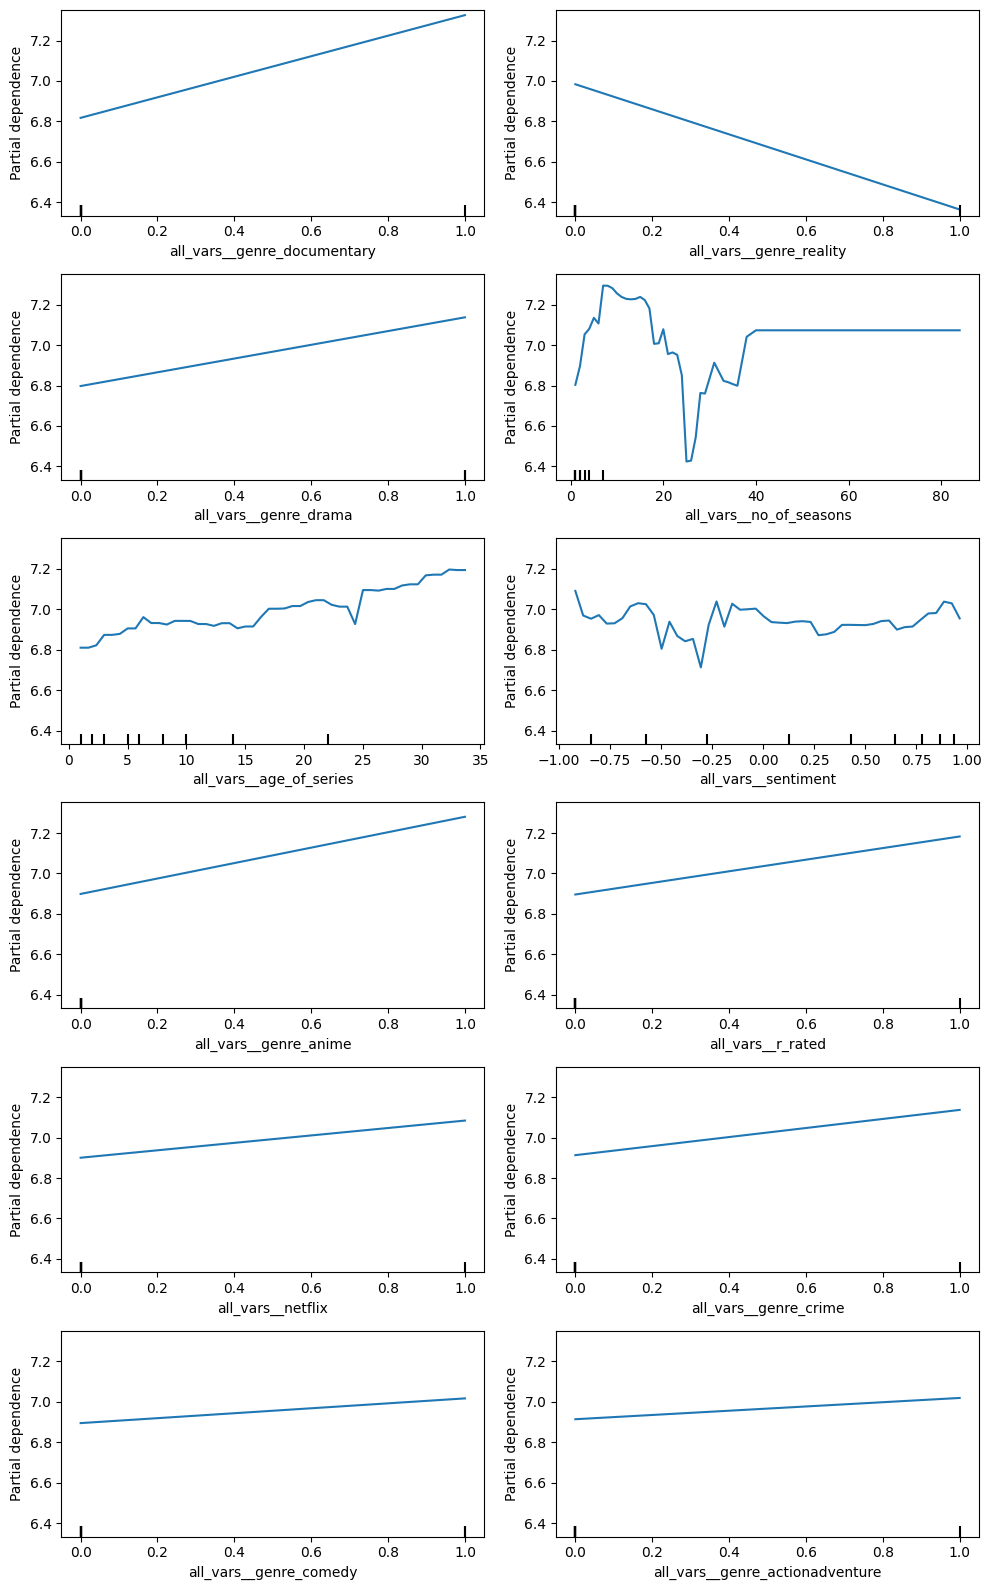

In [20]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(6, 2, figsize=(10, 16)) 
ax = ax.ravel()  

PartialDependenceDisplay.from_estimator(
    models['XGB all vars'].named_steps['model'],
    X_test_transformed_all_xgb,
    features=top_features,
    grid_resolution=50,
    random_state=0,
    kind='average',
    ax=ax, 
    # subsample=100
)

plt.tight_layout()
plt.show()

## Accumulated local effects

ALE plots explain how much individual features are contributing to the predictions (relative to the average predition).
For **No of seasons** variable we can conclude that shows with a high number of seasons are contributing **positively** to the outcome of the model.
For most **genre-related variables**, such as anime or drama, as well as for **R-rated shows**, we observe a **positive effect** on the outcome when the show belongs to these categories.
On the other hand, the variable **drama** is contributing **negatively** to the outcome if the show is of genre drama.

In [51]:
from alibi.explainers import ALE, plot_ale

ale = ALE(predictor=models['XGB all vars'].named_steps['model'].predict, feature_names=models['XGB all vars'].named_steps['preprocess'].get_feature_names_out())

ale_exp = ale.explain(X_test_transformed_all_xgb.to_numpy())

2025-06-01 16:17:15.730350: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-01 16:17:15.755135: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 16:17:15.795995: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 16:17:15.809767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748787435.824458  131881 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748787435.82

/tmp/ipykernel_131881/1244241056.py:1: FutureWarning:

In the future `np.object` will be defined as the corresponding NumPy scalar.



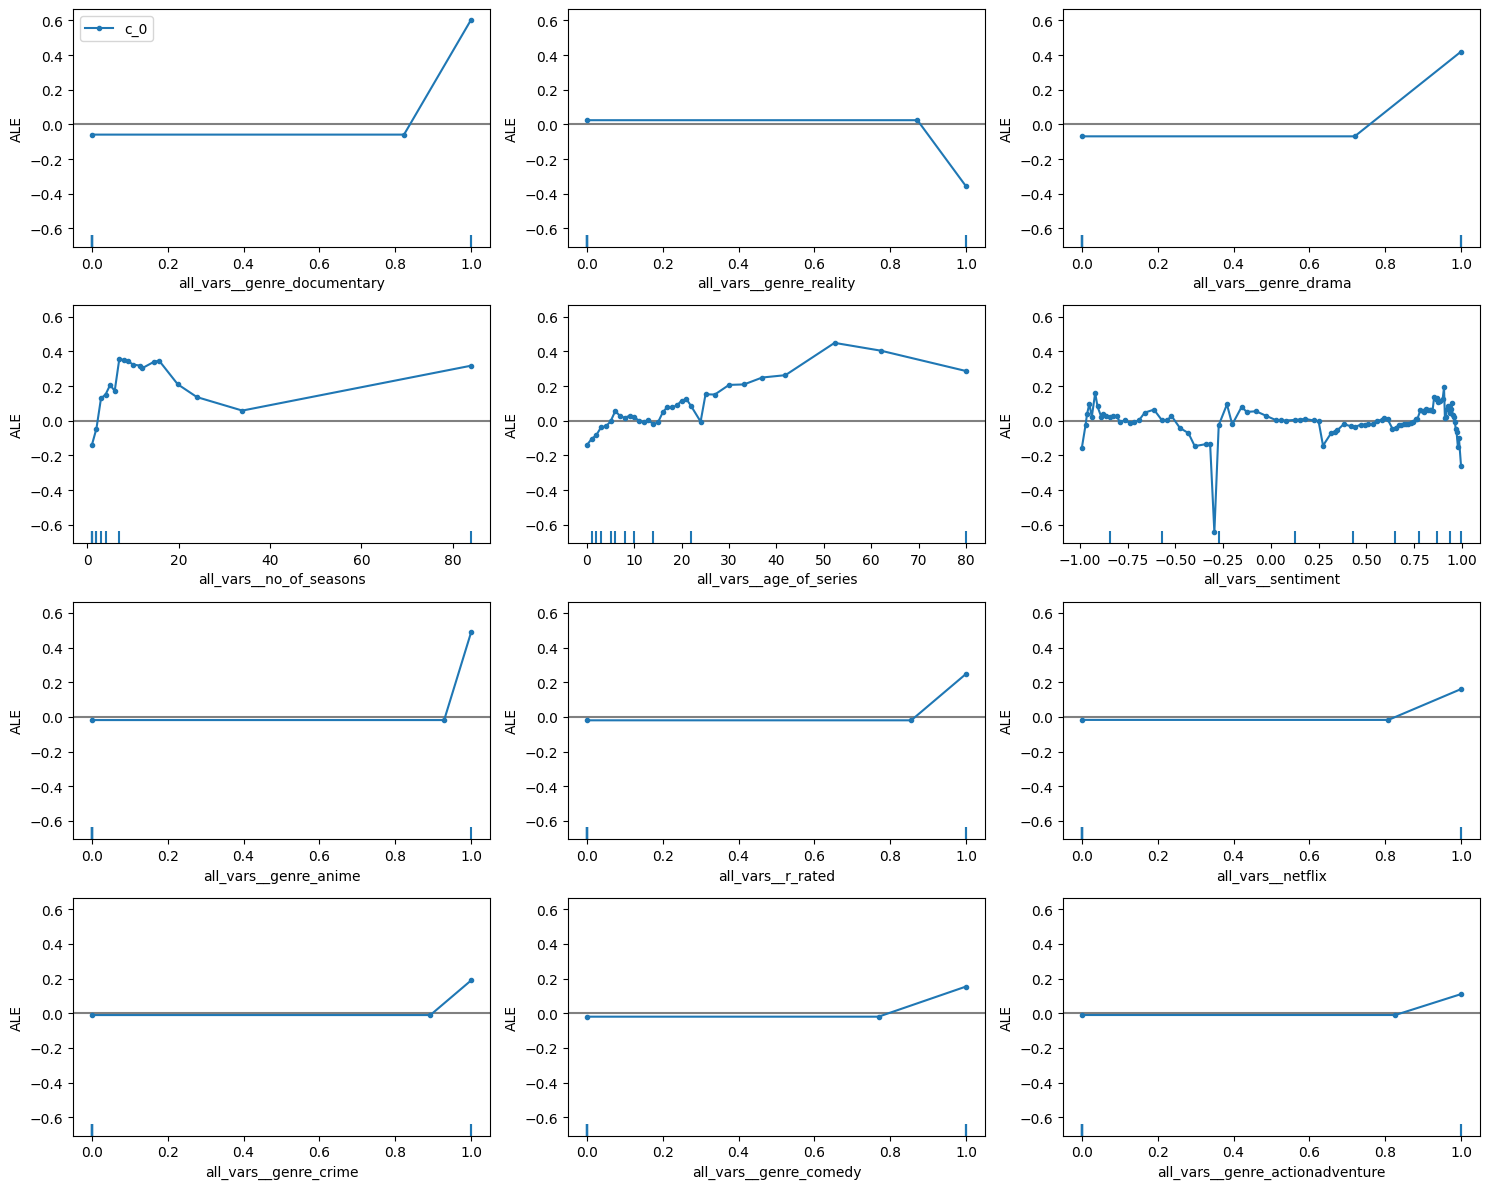

In [53]:
if not hasattr(np, 'object'):
    np.object = object
plot_ale(ale_exp, features=top_features, fig_kw={'figwidth':15, 'figheight': 12})

plt.tight_layout()

## Shapley additive explanations

SHAP value explains if an individual feature is contributing to the model's prediction. 
For most **genre related** variables, when observation is equal to 0, the feature has negative or only a little influence on the outcome. 
With the increase in **age of the show** variable, the SHAP value increases, which suggests that the older the show is, the more its age is contributing to the prediction.

The **global feature importance** plot suggests that **genre documentary** is the strongest predictor. Variables like **number of seasons, R Rated and Netflix** are positively correlated with h=the target.

In [55]:
import shap
shap_explainers = {}
shap_values = {}

for name, model in models.items():

    # Transform the data
    X_test_transformed = pd.DataFrame(
        model.named_steps['preprocess'].transform(X_test),
        columns=model.named_steps['preprocess'].get_feature_names_out()
    )

    # Create SHAP explainer (use TreeExplainer for tree models)
    shap_explainer = shap.Explainer(model.named_steps['model'])
    shap_value = shap_explainer(X_test_transformed)

    # Save
    shap_explainers[name] = shap_explainer
    shap_values[name] = shap_value

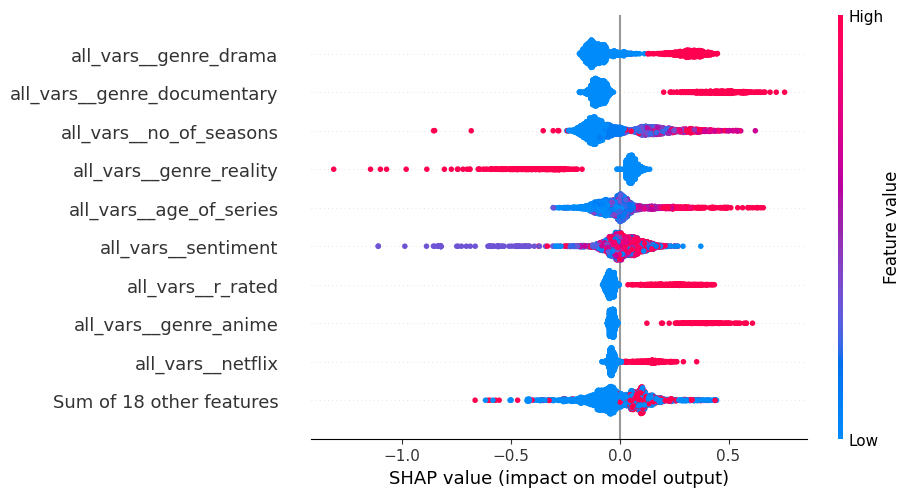

In [56]:
shap.plots.beeswarm(shap_values['XGB all vars'])

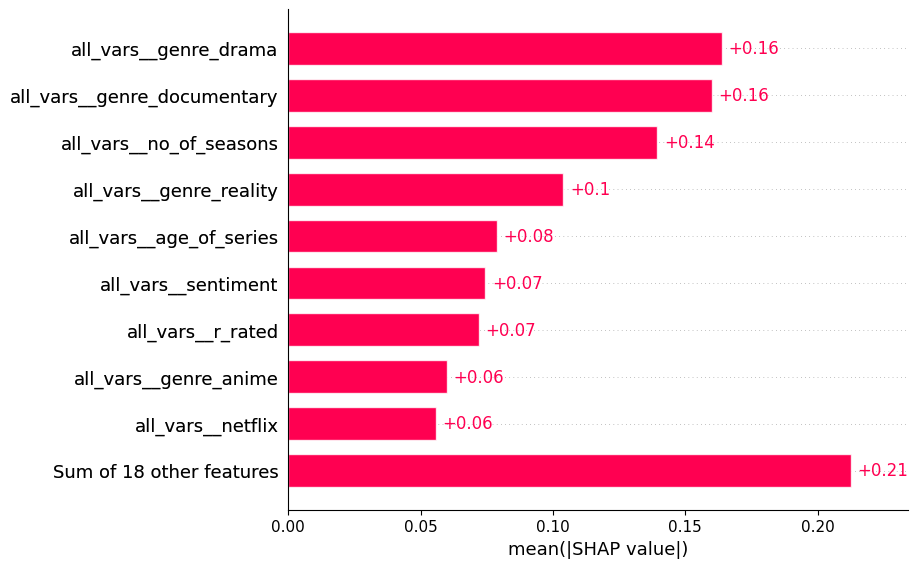

In [57]:

shap.plots.bar(shap_values['XGB all vars'])

SHAP dependence plots illustrate how a feature’s value influences its contribution to the model’s prediction, while also revealing possible interactions with other features. In these plots:

- The x-axis shows the actual value of the selected feature.

- The y-axis shows the SHAP value, indicating how much that feature increases or decreases the prediction.

- The color represents the value of another feature, helping to visualize interactions.

Below, we present dependence plots for the top features. These plots provide insights not only into the individual influence of each feature but also into how their effects may vary depending on the context of other features.

Some key observations from our data:

- Documentary shows tend to have a strong positive impact on predicted ratings. However, when they are also classified as Drama, the positive effect is slightly reduced.

- Reality shows generally lower the predicted rating. If a show is both Reality and Drama, the negative impact is even stronger.

- Shows available on Netflix are associated with higher predicted ratings. However, if those shows are also R-rated, the prediction tends to be slightly lower than other Netflix content.

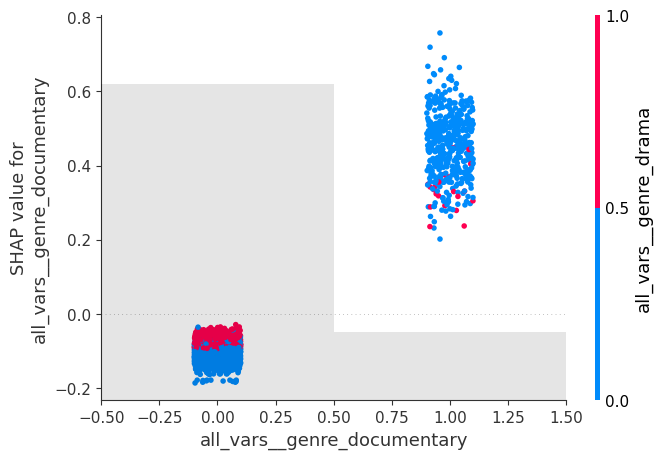

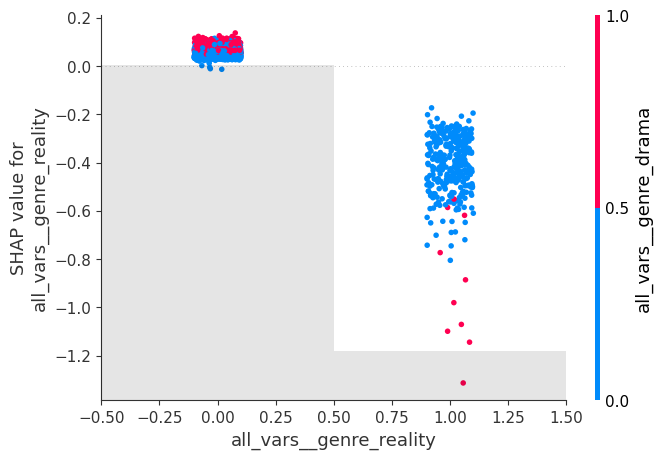

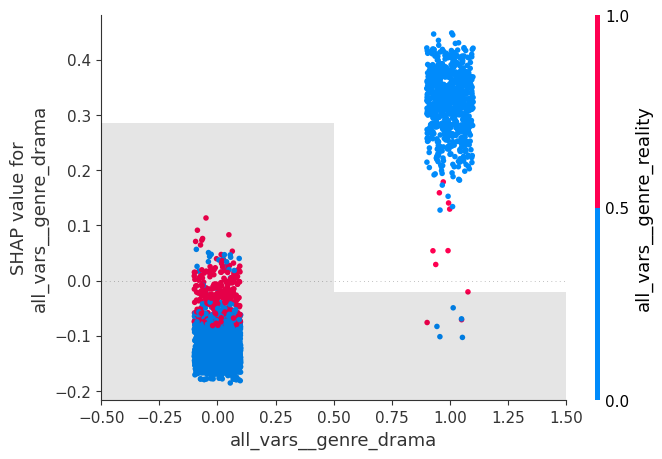

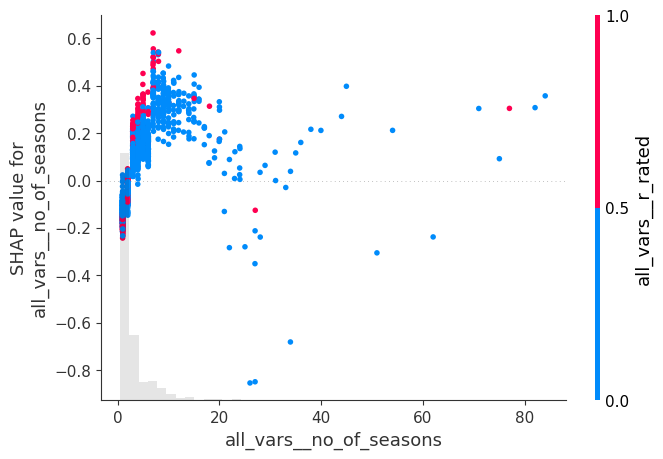

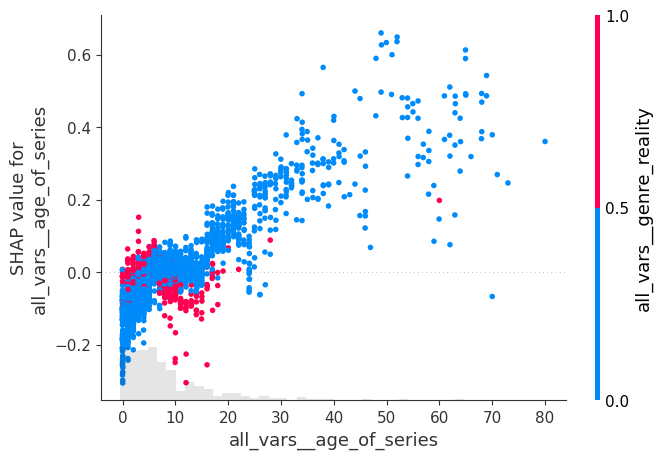

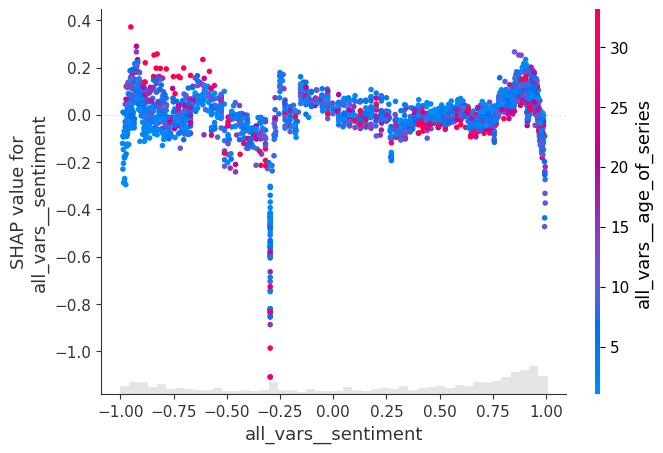

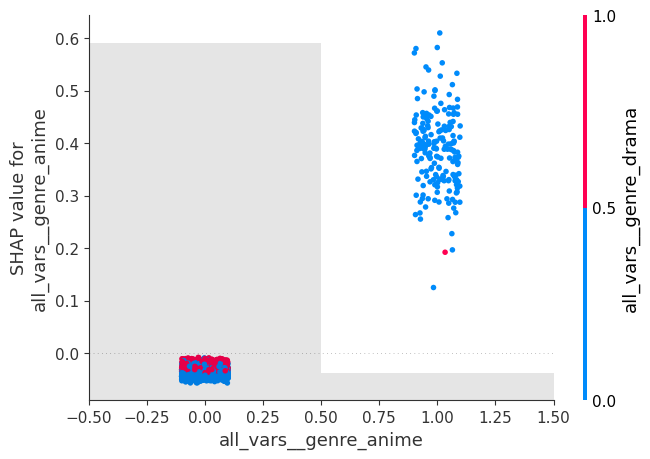

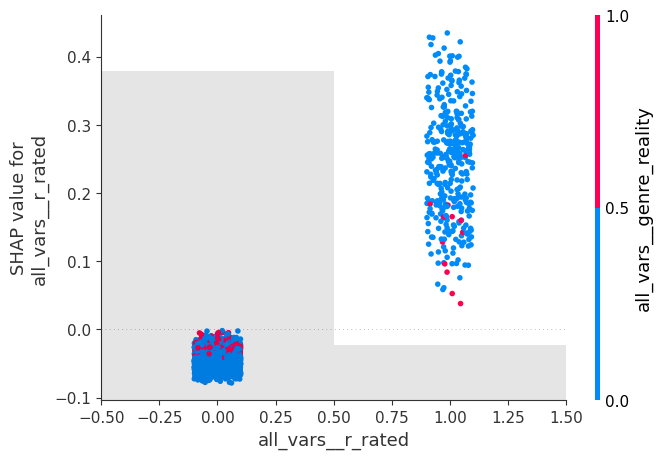

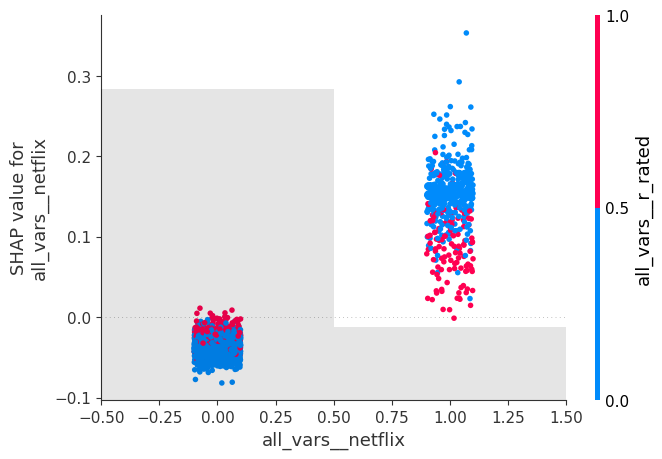

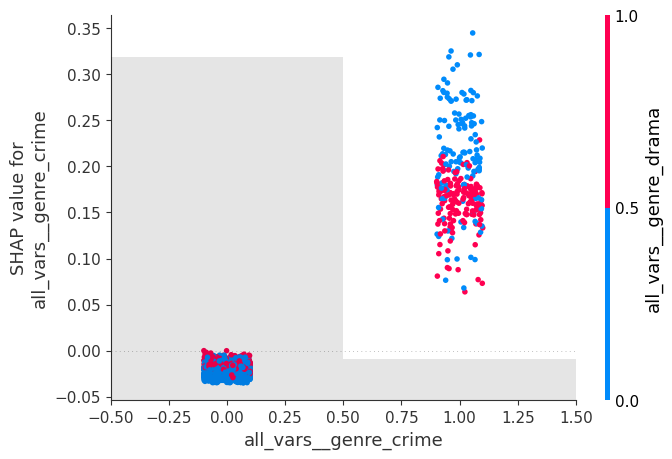

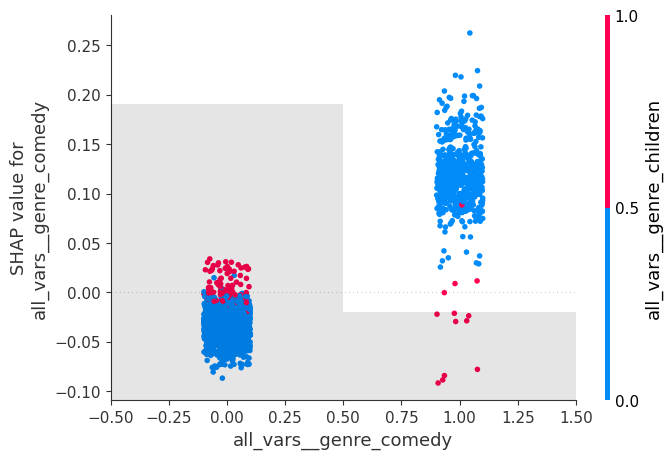

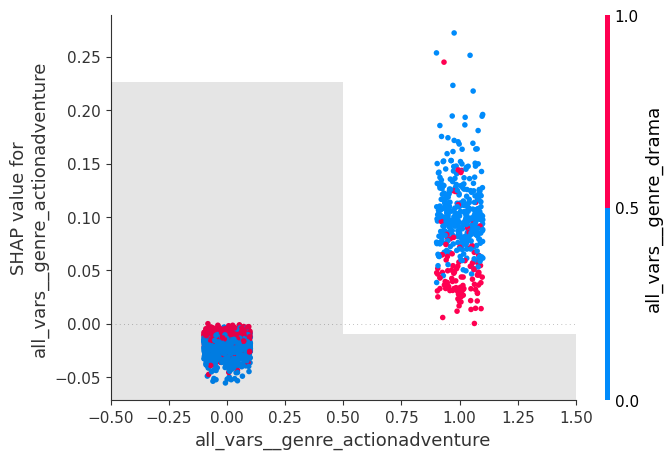

In [58]:
for i in top_features:
    shap.plots.scatter(shap_values['XGB all vars'][:, i], color=shap_values['XGB all vars'])

## The Break Down Method

The waterfall plot explains the significance of individual features on the prediction based on one observation.
For the prediction of 6.9 a lot of features, such as genre drama or number of seasons, have a positive effect on the show rating.

In [ ]:
# We select 138th observation to check how given variables affected its final prediction.
X_test_transformed_all_xgb.iloc[138]

all_vars__age_of_series            4.000
all_vars__r_rated                  0.000
all_vars__no_of_seasons            2.000
all_vars__sentiment                0.359
all_vars__multiple_platforms       0.000
all_vars__netflix                  1.000
all_vars__hulu                     0.000
all_vars__prime_video              0.000
all_vars__true_crime               0.000
all_vars__world_war                0.000
all_vars__award_winning            0.000
all_vars__serial_killer            0.000
all_vars__emmy_award               0.000
all_vars__love                     0.000
all_vars__genre_gameshow           0.000
all_vars__genre_animation          0.000
all_vars__genre_children           0.000
all_vars__genre_crime              0.000
all_vars__genre_drama              1.000
all_vars__genre_anime              0.000
all_vars__genre_comedy             1.000
all_vars__genre_documentary        0.000
all_vars__genre_reality            0.000
all_vars__genre_fiction            0.000
all_vars__genre_

The SHAP waterfall plot shows how different features affect the predicted rating for one specific show. The prediction starts at 6.9, which is the base value before the model looks at any features. At first, smaller features push the prediction slightly up or down. Then we see the biggest positive influences: the show being a Drama and Comedy, being available on Netflix, and not being a Reality show — all of which increase the predicted rating. On the other hand, the rating is pulled down by the show not being a Documentary, having a sentiment score of 0.3, and not being rated R. The plot clearly shows how each feature moves the prediction higher or lower from the starting point of 6.9.

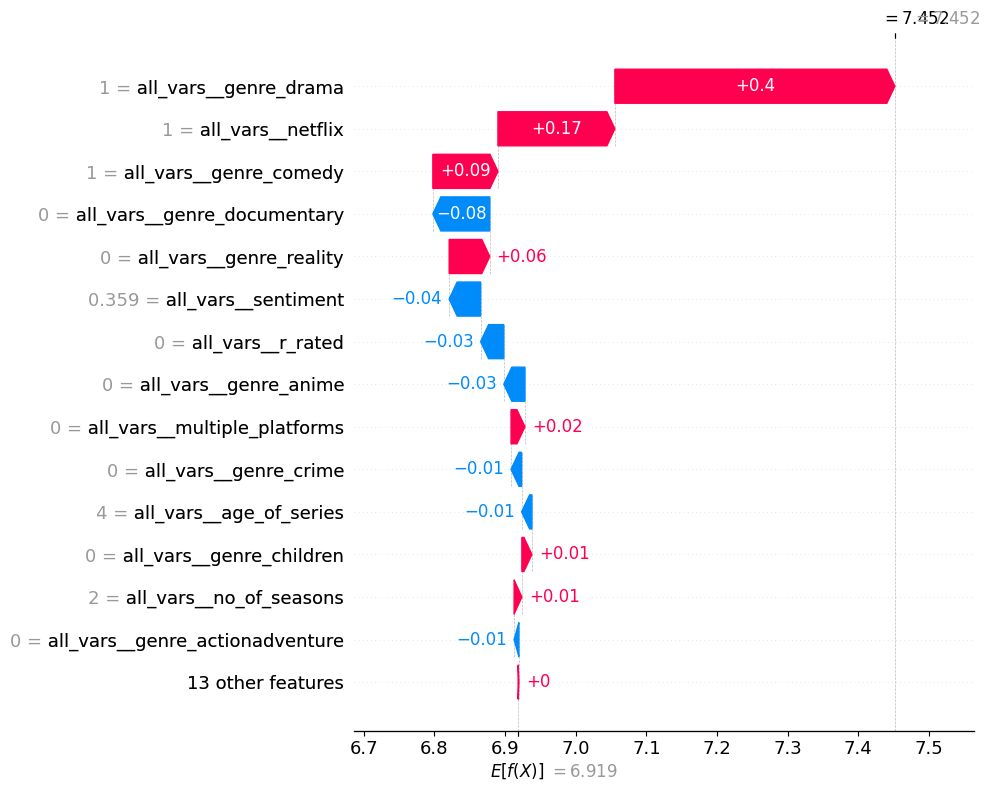

In [60]:
shap.plots.waterfall(shap_values['XGB all vars'][138], max_display=15)

Additionally, the SHAP force plot shows a similar idea by visualizing how each feature "pushes" the prediction higher or lower, helping us understand how the final value is reached.

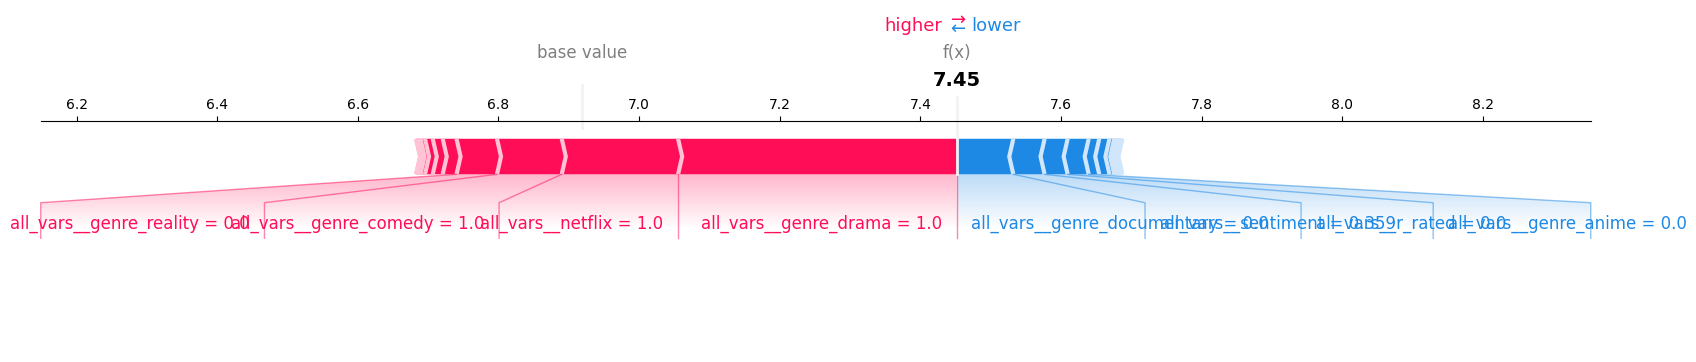

In [ ]:

shap.plots.force(
            shap_values['XGB all vars'][138],
            matplotlib=True,
            show=False
        )